**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from scipy import optimize
import time
import sympy as sm
import matplotlib.pyplot as plt
from types import SimpleNamespace
import numba as nb

import examproject as ep

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
sol = ep.analytical_sol(do_print=True)

Eq(L^*, -kappa/(2*wtilde) + sqrt(4*alpha*wtilde**2 + kappa**2*nu)/(2*sqrt(nu)*wtilde))

Though sympy simplifies the problem sligthly differently, this is equialvent to

$$
L^* = \frac{-\kappa + \sqrt{\kappa^2 + 4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}
$$

As should be verified.

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

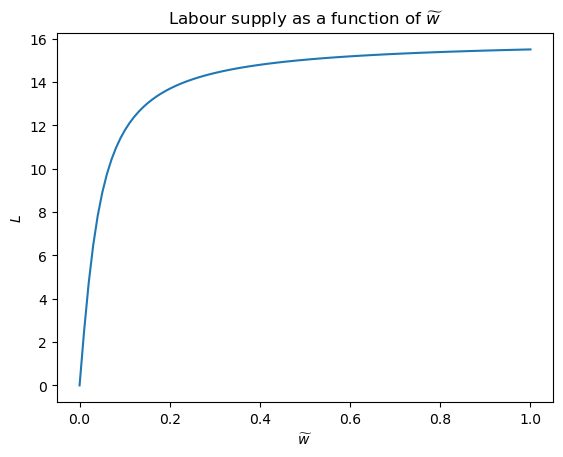

In [3]:
# initialize model class
model = ep.TaxModel()
model.set_values()

# set new parameter values
model.labour_plot()

/Users/johan/Google Drive/04 Økonomi/06 Programming and Nummerical Analysis/02 Git/projects-2023-valros/examproject/examproject.py:133: RuntimeWarning: invalid value encountered in true_divide
  return (-par.kappa + np.sqrt(par.kappa**2 + 4 * (par.alpha/par.nu) * (par.w * (1-tau))**2)) / (2 * par.w * (1-tau))
/Users/johan/Google Drive/04 Økonomi/06 Programming and Nummerical Analysis/02 Git/projects-2023-valros/examproject/examproject.py:184: RuntimeWarning: divide by zero encountered in log
  return np.log(self.consump_fun(tau=tau)**par.alpha * self.govern_fun(tau=tau)**(1-par.alpha)) - par.nu * (self.labour_fun(tau=tau)**2)/2


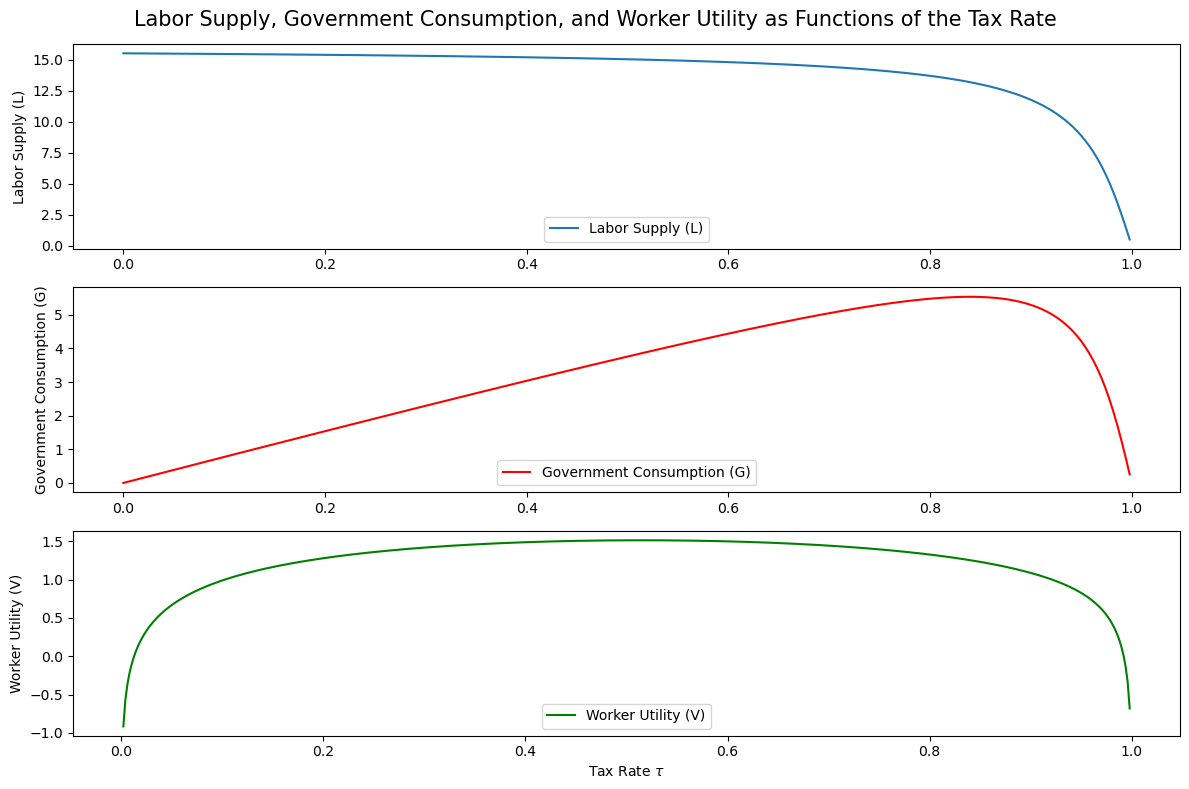

In [4]:
model.tax_plot()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [5]:
# lampdify the labor expanded optimal supply function 
def labour(alpha, nu, kappa, w, tau):
    return (-kappa + np.sqrt(kappa**2 + 4 * (alpha/nu) * (w * (1-tau))**2)) / (2 * w * (1-tau))

# setup function for government
def government(w, tau, alpha, nu, kappa):
    return tau * w * labour(alpha=alpha, nu=nu, kappa=kappa, w=w, tau=tau)

# setup function for consumption
def consumption(w, tau, kappa, alpha, nu):
    return kappa + (1-tau) * w * labour(alpha=alpha, nu=nu, kappa=kappa, w=w, tau=tau)

# setup function for utility
def utility(w, tau, kappa, alpha, nu):
    return np.log(consumption(w=w, tau=tau, kappa=kappa, alpha=alpha, nu=nu)**alpha * government(w=w, tau=tau, alpha=alpha, nu=nu, kappa=kappa)**(1-alpha)) - nu * (labour(alpha=alpha, nu=nu, kappa=kappa, w=w, tau=tau)**2)/2

# create array of tau values and calculate optimal labor supply, government spending, and utility
tau_vec = np.linspace(0.0, 1.0, 1000)
labour_vec = labour(alpha=0.5, nu=1/(2*16**2), kappa=1.0, w=1.0, tau=tau_vec)
gov_vec = government(w=1.0, tau=tau_vec, alpha=0.5, nu=1/(2*16**2), kappa=1.0)
util_vec = utility(w=1.0, tau=tau_vec, kappa=1.0, alpha=0.5, nu=1/(2*16**2))

# Plot L, G, and V as functions of tau
plt.figure(figsize=(12, 8))

# create title for the whole plot
plt.suptitle('Labor Supply, Government Consumption, and Worker Utility as Functions of the Tax Rate', fontsize = 15)

# create fig size
fig.set_figwidth(15)
fig.set_figheight(10)

# create subplots
plt.subplot(3, 1, 1)
plt.plot(tau_vec, labour_vec, label='Labor Supply (L)')
#plt.xlabel('Tax Rate ' +r'$\tau$', fontsize = 10)
plt.ylabel(r'Labor Supply (L)', size = 10)
plt.legend(fontsize = 10, loc = 'lower center')

plt.subplot(3, 1, 2)
plt.plot(tau_vec, gov_vec, label='Government Consumption (G)', color = 'red')
#plt.xlabel('Tax Rate ' +r'$\tau$', fontsize = 10)
plt.ylabel(r'Government Consumption (G)', size = 10)
plt.legend(fontsize = 10, loc = 'lower center')

plt.subplot(3, 1, 3)
plt.plot(tau_vec, util_vec, label='Worker Utility (V)', color = 'green')
plt.xlabel('Tax Rate ' +r'$\tau$', fontsize = 10)
plt.ylabel(r'Worker Utility (V)', size = 10)
plt.legend(fontsize = 10, loc = 'lower center')

plt.tight_layout()
plt.show()


/var/folders/3r/1kv5zyk92gj7vdrjg4lsysm80000gn/T/ipykernel_57658/589932001.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (-kappa + np.sqrt(kappa**2 + 4 * (alpha/nu) * (w * (1-tau))**2)) / (2 * w * (1-tau))
/var/folders/3r/1kv5zyk92gj7vdrjg4lsysm80000gn/T/ipykernel_57658/589932001.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(consumption(w=w, tau=tau, kappa=kappa, alpha=alpha, nu=nu)**alpha * government(w=w, tau=tau, alpha=alpha, nu=nu, kappa=kappa)**(1-alpha)) - nu * (labour(alpha=alpha, nu=nu, kappa=kappa, w=w, tau=tau)**2)/2


NameError: name 'fig' is not defined

<Figure size 1200x800 with 0 Axes>

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [6]:
# function to find the optimal tax rate
def optimal_tax_rate(alpha, nu, kappa, w):
    obj = lambda tau: -utility(w=w, tau=tau, kappa=kappa, alpha=alpha, nu=nu)

    # solve for the optimal tax rate using Nelder-Mead minimization
    optimal_tau = optimize.minimize(obj, x0=0.5, method = 'BFGS').x[0]

    # return the optimal tax rate
    return optimal_tau

# calculate the optimal tax rate
optimal_tau = optimal_tax_rate(alpha=0.5, nu=1/(2*16**2), kappa=1.0, w=1.0)

print(optimal_tau)


0.5145311131890474


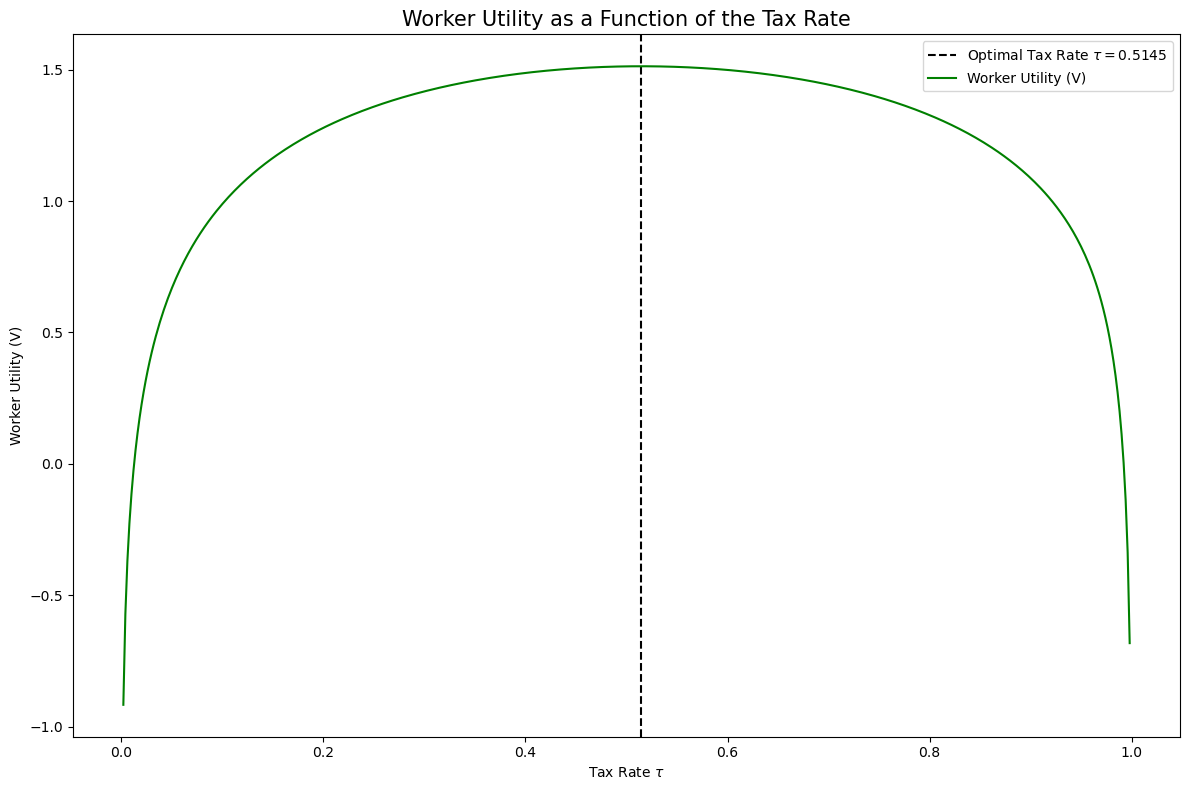

In [ ]:
opt_tax = model.optimal_tax(do_print=False, do_plot=True)


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [7]:
def worker_problem(alpha, sigma, rho, nu, epsilon, kappa, tau, w, G):
    # setup the objective function
    obj = lambda L: - ((((alpha*(kappa + (1-tau) * w * L)**((sigma-1)/sigma) 
                          + (1-alpha)*G**((sigma-1)/sigma))**(sigma/(sigma-1)))**(1-rho) - 1) 
                          / (1-rho) - nu * L**(1+epsilon) / (1+epsilon))

    # solve for the optimal labor supply using BFSG minimization
    res = optimize.minimize(obj, x0=12, bounds=[(0,24)], method = 'Nelder-Mead')

    return res.x[0]

# calculate the optimal labor supply


def g_solver(alpha, sigma, rho, nu, epsilon, kappa, tau, w):
    # setup the objective function
    obj = lambda G: G - tau * w * worker_problem(alpha=alpha, sigma=sigma, rho=rho, nu=nu, epsilon=epsilon, kappa=kappa, tau=tau, w=w, G=G)
    # solve for the optimal labor supply using BFSG minimization
    res = optimize.root_scalar(obj, bracket=(0,24), method = 'brentq')

    return res.root

sol = g_solver(alpha=0.5, sigma=1.001, rho=1.001, nu=1/(2*16**2), epsilon=1, kappa=1.0, tau=optimal_tau, w=1.0)
print(sol)

7.711221014051962


In [8]:
g_opt1 = model.gov_opt(sigma=1.001, rho=1.001, tau = opt_tax, do_print=True)
g_opt2 = model.gov_opt(sigma=1.5, rho=1.5, tau = opt_tax, do_print=True)

NameError: name 'opt_tax' is not defined

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [9]:
def util(alpha, sigma, rho, nu, epsilon, kappa, w, tau):
    # setup the objective function
    Gstar = g_solver(alpha=alpha, sigma=sigma, rho=rho, nu=nu, epsilon=epsilon, kappa=kappa, tau=tau, w=w)
    Lstar = worker_problem(alpha=alpha, sigma=sigma, rho=rho, nu=nu, epsilon=epsilon, kappa=kappa, tau=tau, w=w, G=Gstar)
    util = ((((alpha * (kappa + (1 - tau) * w * Lstar) ** ((sigma - 1) / sigma) 
                + (1 - alpha) * Gstar ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho) - 1) / (1 - rho) 
                - nu * Lstar ** (1 + epsilon) / (1 + epsilon))
    return util

obj = lambda tau: - util(alpha=0.5, sigma=1.001, rho=1.001, nu=1/(2*16**2), epsilon=1, kappa=1.0, w=1.0, tau=tau)

res = optimize.minimize(obj, x0=0.5, bounds=[(0,1)], method = 'Nelder-Mead')

print(res.x[0])

0.5140625


In [10]:
opt_tax1 = model.optimal_tax_ext(sigma=1.001, rho=1.001, do_print=True)
opt_tax2 = model.optimal_tax_ext(sigma=1.5, rho=1.5, do_print=True)

The optimal tax rate is 0.5141.
The optimal tax rate is 0.4621.


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

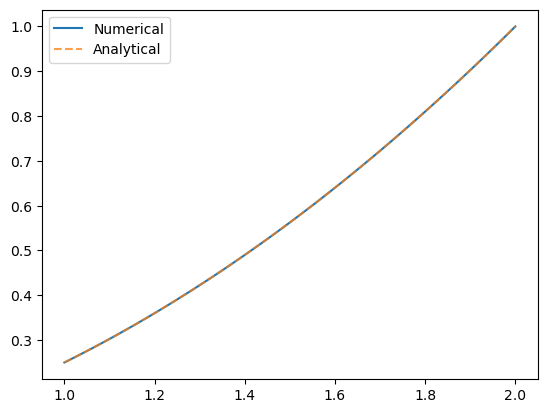

In [11]:
model = ep.LabourClass()
model.set_values()

kappa_vec = np.linspace(1.0, 2.0, 100)

l_vec = np.empty(100)
l_analytical = np.empty(100)

for i, kappa in enumerate(kappa_vec):
    l_vec[i] = model.optimal_l(kappa=kappa)
    l_analytical[i] = model.analytical_l(kappa=kappa)

plt.plot(kappa_vec, l_vec, label='Numerical')
plt.plot(kappa_vec, l_analytical, linestyle='--', alpha=0.75, label='Analytical')
plt.legend()
plt.show()

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [12]:
np.random.seed(2023)
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_eps = 0.10
R = (1+0.01)**(1/12)
T = 120
K = 10000

# calculated the random shocks
eps = np.random.normal(-0.5*sigma_eps**2, sigma_eps, (K,T))



# calculate the log of kappa and kappa
log_kappa = np.zeros((K,T+1)) # with zeros the first column is already 0 as it should be

# calculate the log of kappa
for t in range(1, T+1):
    log_kappa[:,t] = rho * log_kappa[:,t-1] + eps[:,t-1]

# calculate kappa
kappa = np.exp(log_kappa)

@nb.njit(parallel=True)
def ex_post(R, kappa, l, w, eta, iota, t, T, K):
    # calculate the ex-post value of the salon
    single_period_value = np.zeros((K,T+1))
    iota_mat = np.zeros((K,T+1))

    for t in range(0,T+1):
        for k in range(0,K):
            if l[k,t] == l[k,t-1]:
                iota_mat[k,t] = 0
            else:
                iota_mat[k,t] = iota

    for t in range(1, T+1):
        single_period_value[:,t] = R**(-t) * (kappa[:,t]*l[:,t]**(1-eta)-w*l[:,t]-iota_mat[:,t])
    
    return np.sum(single_period_value, axis=1)

def policy1(eta, kappa, w):
    # calculate the optimal labor supply
    l = np.zeros((K,T+1))
    for t in range(1, T+1):
        l[:,t] = ((eta*kappa[:,t])/w)**(1/(1-eta)) 

    return l

l1 = policy1(eta=0.5, kappa=kappa, w=1.0)

test = ex_post(R=R, kappa=kappa, l=l1, w=w, eta=eta, iota=iota, t=1, T=T, K=K)

def ex_ante(R, kappa, l, w, eta, iota, t, T, K):

    val = ex_post(R, kappa, l, w, eta, iota, t, T, K)

    return 1 / K * np.sum(val, axis=0)

ex_ante(R=R, kappa=kappa, l=l1, w=w, eta=eta, iota=iota, t=1, T=T, K=K)


27.730190544942932

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [13]:
@nb.njit(parallel=True)
def policy2(eta, kappa, w, Delta=0):
    # calculate the optimal labor supply
    l = np.zeros((K,T+1))
    for t in range(1, T+1):
        l[:,t] = ((eta*kappa[:,t])/w)**(1/(1-eta)) 

    if Delta != 0:
        for t in range(1, T+1):
            for k in range(0,K):
                if np.abs(l[k,t-1] - l[k,t]) <= Delta:
                    l[k,t] = l[k,t-1]                

    return l


In [14]:
l1 = policy2(eta=0.5, kappa=kappa, w=1.0, Delta=0)
l2 = policy2(eta=0.5, kappa=kappa, w=1.0, Delta=0.05)
ex_ante(R=R, kappa=kappa, l=l1, w=w, eta=eta, iota=iota, t=1, T=T, K=K)
ex_ante(R=R, kappa=kappa, l=l2, w=w, eta=eta, iota=iota, t=1, T=T, K=K)

28.410320997790382

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [15]:
def optimal_delta(R=R, kappa=kappa, l=l1, w=w, eta=eta, iota=iota, t=1, T=T, K=K):
    obj = lambda Delta: - ex_ante(R=R, kappa=kappa, l=policy2(eta=eta, kappa=kappa, w=w, Delta=Delta), w=w, eta=eta, iota=iota, t=t, T=T, K=K)

    res = optimize.minimize_scalar(obj, bounds=(0,1), method='bounded')

    return res.x

In [23]:
delt_opt = optimal_delta(R=R, kappa=kappa, l=l1, w=w, eta=eta, iota=iota, t=1, T=T, K=K)

In [16]:
def plot_delta(R=R, kappa=kappa, l=l1, w=w, eta=eta, iota=iota, t=1, T=T, K=K):
    Delta_vec = np.linspace(0,1,100)
    val = ex_ante(R=R, kappa=kappa, l=policy2(eta=eta, kappa=kappa, w=w, Delta=Delta_vec), w=w, eta=eta, iota=iota, t=t, T=T, K=K)

    plt.plot(Delta_vec, val)
    plt.show()

In [27]:
delta_vec = np.linspace(0,1,100)
val = np.zeros(100)
for i in range(0,100):
    val[i] = ex_ante(R=R, kappa=kappa, l=policy2(eta=eta, kappa=kappa, w=w, Delta=delta_vec[i]), w=w, eta=eta, iota=iota, t=1, T=T, K=K)

In [21]:
print(val)

[27.73019054 27.93978793 28.11879674 28.25541148 28.35066265 28.41286452
 28.44876259 28.46495723 28.46572146 28.45379149 28.43230648 28.40273448
 28.36582181 28.32109604 28.27038362 28.2140435  28.14998698 28.07768256
 27.99275715 27.89604486 27.77897997 27.62749096 27.45351304 27.23220997
 26.97801768 26.67503658 26.34438643 25.9617807  25.54640706 25.10893318
 24.59075543 24.07165211 23.52775931 22.94731528 22.3210588  21.69542247
 21.05311377 20.36176358 19.69098875 18.98080598 18.26992563 17.53388821
 16.81446147 16.06387564 15.32234322 14.63750947 13.90275163 13.16914265
 12.50565329 11.8296989  11.15875371 10.50944543  9.9019765   9.30404362
  8.70411425  8.1279166   7.60011309  7.10446828  6.64673591  6.2137016
  5.83182061  5.43478644  5.07226555  4.69993883  4.38256463  4.07081609
  3.79926752  3.50399509  3.25077593  3.01312352  2.78299458  2.56650566
  2.36756079  2.17336361  2.01927338  1.86950342  1.73380781  1.58910905
  1.45959776  1.36109212  1.23431521  1.13037313  1.

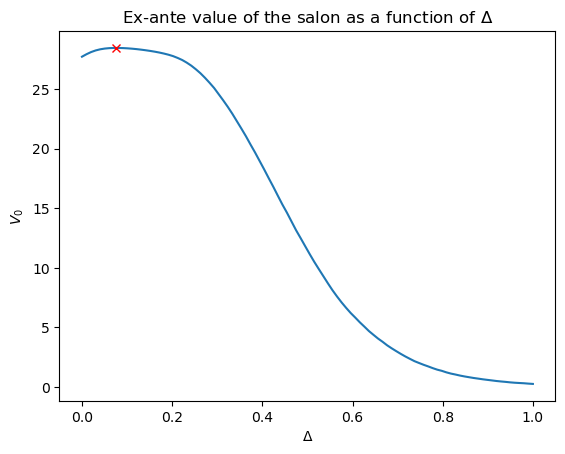

In [28]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.plot(delta_vec, val)
ax.set_xlabel(r'$\Delta$')
ax.set_ylabel(r'$V_0$')
# mark the optimal delta
ax.plot(delt_opt,ex_ante(R=R, kappa=kappa, l=policy2(eta=eta, kappa=kappa, w=w, Delta=delt_opt), w=w, eta=eta, iota=iota, t=1, T=T, K=K), 'rx')
ax.set_title(r'Ex-ante value of the salon as a function of $\Delta$')
plt.show()


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [ ]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

To solve this we call the ```griewank_minimizer``` defined in [examproject.py](examproject.py)

In [ ]:
sol10 = ep.griewank_minimizer(do_print = True)
print(f'Is close to true global mimum: {np.isclose(sol10["value"], 0)}')

The global minimum is approximately: f = 1.56e-12
The solution is x_1 = 9.47e-07 and x_2 = -2.11e-06 
Iterations: 369


We see that our solution is practically equal to the true global minimum, which is what we want. This took 369 iterations to find.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

We again call the ```griewank_minimizer``` defined in [examproject.py](examproject.py) now with $\underline{K} = 100$.

In [ ]:
sol100 = ep.griewank_minimizer(warm_up_K=100, do_print = True)
print(f'Is close to true global mimum: {np.isclose(sol100["value"], 0)}')

The global minimum is approximately: f = 1.06e-12
The solution is x_1 = -1.30e-06 and x_2 = 9.22e-07 
Iterations: 353
Is close to true global mimum: True


We again get a result practically equal to the true global minimum. This time it took 353 iterations to find. Thus it did converge faster.
However, we do not know if it takes longer to run thus, we will test this.

In [ ]:
%timeit -n 10 -r 5 ep.griewank_minimizer()
%timeit -n 10 -r 5 ep.griewank_minimizer(warm_up_K=100)

461 ms ± 4.81 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
453 ms ± 12 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


We aditionally see that the function also runs faster with $\underline{K} = 100$. Thus we conclude that for this seed (2023) it is a better idea to set $\underline{K} = 100$. However, this might differ for other seeds as the time it takes to run the function is very close to the same.

In [ ]:
# defining the global minmizer with multi-start method
def griewank_minimizer(brackets = [-600,600], tau = 10**(-8), warm_up_K = 10, K = 1000, seed = 2023, do_print = False):
    """
    The refined global minimizer of the Griewank function using a multi-start method.

    Parameters
        brackets (array): the brackets for the uniform distribution
        tau (float): the threshold for the stopping criterion
        warm_up_K (int): the number of iterations before the algorithm starts updating x
        K (int): the number of iterations
        seed (int): the seed for the random number generator
        do_print (bool): whether to print the result

    Returns
        dict: a dictionary with the solution, the number of iterations and the value of the function
    """

    np.random.seed(seed)
    # a. draw random points from the uniform distribution
    x = np.random.uniform(brackets[0],brackets[1],(K,2))
    #x2 = np.random.uniform(brackets[0],brackets[1],K)
    #x = np.array([x1,x2]).T

    # set number of iterations to 0
    k = 0
    while k < K:
        # b. control if still warming up
        if k >= warm_up_K:
            # c. calculate chi_k 
            chi_k = 0.5 * (2 / (1 + np.exp((k - warm_up_K) / 100)))
            # d. update x
            x[k] = chi_k*x[k] + (1-chi_k)*x_star
        # e. minimize using the scipy.optimize.minimize with BFGS method
        x_opt = optimize.minimize(fun=griewank, x0=x[k], method = 'BFGS').x
        # f. set optimal value as x_star
        if k == 0:
            x_star = x_opt
        elif griewank(x_opt) < griewank(x_star):
            x_star = x_opt
        # update k
        k += 1
        # g. check if x_star is below threshold
        if griewank(x_star) < tau:
            value = griewank(x_star)
            if do_print:
                print(f'The global minimum is approximately: f = {value:.2e}\n' 
                      f'The solution is x_1 = {x_star[0]:.2e} and x_2 = {x_star[1]:.2e} \n'
                      f'Iterations: {k}')
            # 4. return x_star as x_star and k as number of iterations as a dictionary
            return {'sol':x_star, 'iter':k, 'value':value}

The global minimum is approximately: f = 1.56e-12
The solution is x_1 = 9.47e-07 and x_2 = -2.11e-06 
Iterations: 369
Is close to true global mimum: True
